In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.sr_ut as sut
import resources.chart_kwargs as ck

# images and display
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display

from myst_nb import glue

# set some parameters:
start_date = "2020-03-01"
end_date ="2021-05-31"
start_end = [start_date, end_date]
a_fail_rate = 50
unit_label = "p/100m"
reporting_unit = 100
a_color = "dodgerblue"

# colors for gradients and charts
cmap2 = ck.cmap2
colors_palette = ck.colors_palette

# colors for the individual survey areas
bassin_pallette = {"rhone":"dimgray", "aare":"salmon", "linth":"tan", "ticino":"steelblue", "reuss":"purple"}

# set the maps
bassin_map = PILImage.open("resources/maps/lakes_rivers_map.jpeg")

# define the feature level and components
this_level = "river_bassin"
comps = ["linth", "rhone", "aare", "ticino"]

# proper labels for charts and tables
comp_labels = {"linth":"Linth/Limmat", "rhone":"Rhône", "aare":"Aare", "ticino":"Ticino/Cerisio", "reuss":"Reuss"}
top_name = ["All survey areas"]
# comp_palette = {"Linth/Limmat":"dimgray", "Rhône":"tan", "Aare":"salmon", "Ticino/Cerisio":"steelblue", "Reuss":"purple"}

# common aggregations
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# aggregation of dimensional data
agg_dims = {"total_w":"sum", "mac_plast_w":"sum", "area":"sum", "length":"sum"}

# columns needed
use_these_cols = ["loc_date" ,
                  "% buildings",
                  "% to trans", 
                  "% recreation",
                  "% ag",
                  "% woods",
                  "population",
                  this_level,
                  "water_name_slug",
                  "streets km",
                  "intersects",
                  "length",
                  "groupname",
                  "code"
                 ]

# get the data:
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# make any adjustments to code definitions here:
dfCodes.set_index("code", inplace=True)

# the surveyor designated the object as aluminum instead of metal
dfCodes.loc["G708", "material"] = "Metal"

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code materials
code_material_map = dfCodes.material

(allsurveys)=
# Lakes and rivers

Map of survey locations IQAASL April 2020 - May 2021.

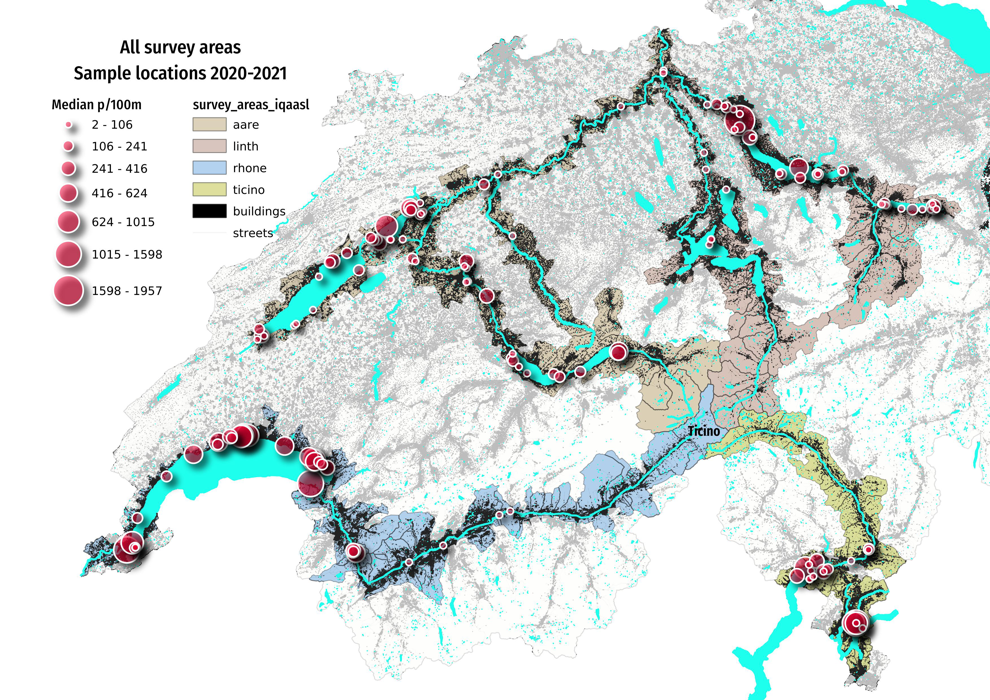

In [2]:
bassin_map.thumbnail((1200,700))
display(bassin_map)

```{figure} resources/maps/lakes_rivers_map.jpeg
:figwidth: 800px
:name: "eosmap"

` `

```

{numref}`Figure {number} <eosmap>`: The survey locations were grouped by survey area for analysis. The size of the marker is set by the median survey total for that location. 

## Land use profile

The survey areas are grouped by river catchment systems, this report combines several catchment areas for analysis of regional trends: 

1. Aare : Emme, Aare
2. Linth/Limmat : Reuss, Linth, Limmat
3. Rhône: Rhône
4. Ticino/Cerisio : Ticino, Lago di Lugano, Laggo Maggiore

The land use profile is the percent of total area attributed to each land use category within a 1500m radius of each survey location. 

1. \% of land attributed to buildings
2. \% of land attributed to agriculture
3. \% of land attributed to forestry
4. \% of land attributed to recreation

Streets are reported as the total number of kilometers of streets within the 1500m radius. Intersects are an ordinal ranking of the number of rivers/canals that intersect a lake within 1500m of the survey location. 

The ratio of the number of samples completed at the different land use profiles is an indicator of the environmental and economic conditions that the samples were taken in. 

__Distribution of land use characteristics__

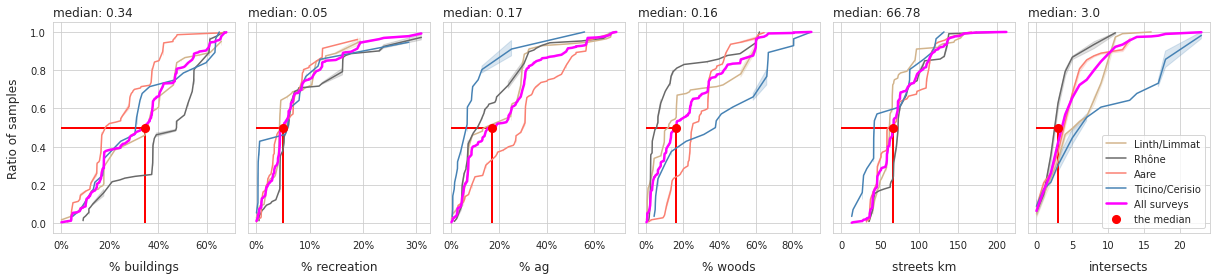

In [3]:
# this is the data before the expanded fragmented plastics and foams are aggregated to Gfrags and Gfoams
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")
before_agg["loc_date"] = list(zip(before_agg.location, before_agg["date"]))

# this is the aggregated survey data that is being used
fd = pd.read_csv(F"resources/checked_sdata_eos_2020_21.csv")
fd["loc_date"] = list(zip(fd.location, fd["date"]))

fd.rename(columns={"% to agg":"% ag", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings"}, inplace=True)
luse_exp = ["% buildings", "% recreation", "% ag", "% woods", "streets km", "intersects"]

# this is the data before the expanded fragmented plastics and foams are aggregated to Gfrags and Gfoams
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")
before_agg["loc_date"] = list(zip(before_agg.location, before_agg["date"]))

# this is the aggregated survey data that is being used
fd = pd.read_csv(F"resources/checked_sdata_eos_2020_21.csv")
fd["loc_date"] = list(zip(fd.location, fd["date"]))

# ["% to buildings", "% to recreation", "% to agg", "% to woods", "streets km", "intersects"]
fd.rename(columns={"% to agg":"% ag", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings"}, inplace=True)
luse_exp = ["% buildings", "% recreation", "% ag", "% woods", "streets km", "intersects"]
# cumulative statistics for each code
code_totals = sut.the_aggregated_object_values(fd, agg=agg_pcs_median, description_map=code_description_map, material_map=code_material_map)    

dt_nw = fd.groupby(use_these_cols[:-2], as_index=False).agg({unit_label:"sum"})

sns.set_style("whitegrid")

fig, axs = plt.subplots(1,len(luse_exp), figsize=(17,4), sharey=True)

for i, n in enumerate(luse_exp):
    # get the dist for each survey area here
    for element in comps:
        ax=axs[i]
        the_data = ECDF(dt_nw[dt_nw[this_level] == element][n].values)
        sns.lineplot(x=the_data.x, y=the_data.y, ax=ax, label=comp_labels[element], color=bassin_pallette[element])
    
    # get the dist for all here
    a_all_surveys =  ECDF(dt_nw[n].values)
    sns.lineplot(x=a_all_surveys.x, y=a_all_surveys.y, ax=ax, label="All surveys", color="magenta", linewidth=2.5)
 
    # get the median from the data
    the_median = np.median(dt_nw[n].values)
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color="red",s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color="red", linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color="red", linewidth=2)
    
    # format the % of total on the xaxis:
    if i <= 3:
        if i == 0:            
            ax.set_ylabel("Ratio of samples", **ck.xlab_k)
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, "%"))        
    else:
        pass
    
    ax.set_xlabel(n, **ck.xlab_k)
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_title(F"median: {(round(the_median, 2))}",fontsize=12, loc="left")

plt.legend(handles, labels)       
plt.tight_layout()

glue("eosluse", fig, display=False)
plt.show()  

```{glue:figure} eosluse
---
name: "eos_luse"
---

` `

```
{numref}`Figure {number}: <eos_luse>` The survey locations in the Rhône and Linth/Limmat survey areas had the greatest median amount of land attributed to buildings at 47% and 40% and the least amount attributed to woods at 5% and 8% respectively. The Aare survey area had the lowest median amount of land attributed to buildings at 16% and the greatest amount of land attributed to agriculture at 30%. The land attributed to recreation represents sports fields, public beaches and other public gathering places. 

## Cumulative totals by survey area

The survey result totals are aggregated for each survey area

In [4]:
# aggregate the dimensional data
dims_parameters = dict(this_level=this_level, 
                       locations=fd.location.unique(), 
                       start_end=start_end, 
                       agg_dims=agg_dims)

dims_table = sut.gather_dimensional_data(dfDims, **dims_parameters)

dt_all = fd.groupby(["loc_date","location",this_level, "city","date"], as_index=False).agg({unit_label:"sum", "quantity":"sum"})

for name in dims_table.index:
    dims_table.loc[name, "samples"] = fd[fd[this_level] == name].loc_date.nunique()
    dims_table.loc[name, "quantity"] =fd[fd[this_level] == name].quantity.sum()

# add proper names for display
dims_table["Survey area"] = dims_table.index.map(lambda x: comp_labels[x])
dims_table.set_index("Survey area", inplace=True)
   
# get the sum of all survey areas
dims_table.loc["All survey areas"]= dims_table.sum(numeric_only=True, axis=0)

# for display
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)
dims_table.rename(columns={"samples":"samples","quantity":"items", "total_w":"total kg", "mac_plast_w":"plastic kg", "area":"m²", "length":"meters"}, inplace=True)

# format kilos and text strings
dims_table["plastic kg"] = dims_table["plastic kg"]/1000
dims_table[["m²", "meters", "samples", "items"]] = dims_table[["m²", "meters", "samples", "items"]].applymap(lambda x: "{:,}".format(int(x)))
dims_table[["plastic kg", "total kg"]] = dims_table[["plastic kg", "total kg"]].applymap(lambda x: "{:.2f}".format(x))

# figure caption
agg_caption = F"""
*{top_name[0]}: table of results. The cumulative weights and measures for each survey area.*
"""
md(agg_caption)


*All survey areas: table of results. The cumulative weights and measures for each survey area.*


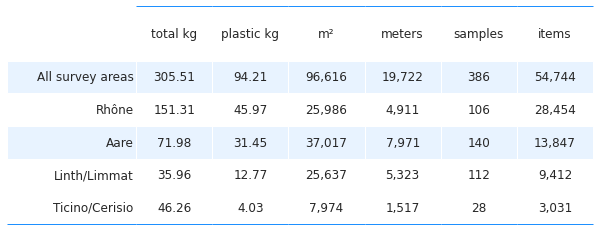

In [5]:
# make table
data = dims_table.reset_index()

fig, axs = plt.subplots(figsize=(len(data.columns)*1.5,len(data)*.8))
sut.hide_spines_ticks_grids(axs)

table_one = sut.make_a_table(axs, data.values, colLabels=data.columns, colWidths=[.22, *[.13]*6],a_color=a_color)
table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
glue("eos_summary_sarea", fig, display=False)
plt.close()

```{glue:figure} eos_summary_sarea
:name: "eos_summary_sarea"


` `

```

{numref}`Figure {number}: <eos_summary_sarea>` Dimensional result totals for all survey areas. The Aare survey area had the greatest number of samples and the least number of total objects collected.  

## Survey results all objects

__Distribution of survey results__

In [6]:
# the surveys to chart
dt_all["date"] = pd.to_datetime(dt_all["date"], format="%Y-%m-%d")
fd_n_samps = dt_all.loc_date.nunique()
fd_dindex = dt_all.set_index("date")

# monthly median survey total
monthly_plot = fd_dindex[unit_label].resample("M").median()

# scale the chart as needed to accomodate for extreme values
y_lim = 95
y_limit = np.percentile(dt_all[unit_label], y_lim)

# figure caption
# chart_notes = F"""
# *__Left:__ {top_name[0]}, {start_date[:7]} through {end_date[:7]}, n={fd_n_samps}. {not_included}*
# """
# md(chart_notes )

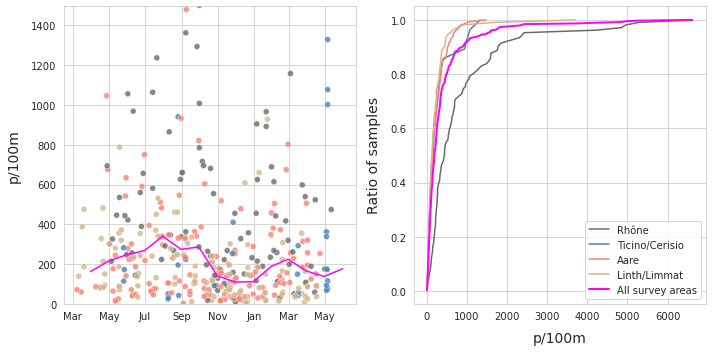

In [7]:
# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months_loc = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
# days = mdates.DayLocator(interval=7)

fig, axs = plt.subplots(1,2, figsize=(10,5))

rate = "Monthly"

line_label = "monthly median"

ax = axs[0]
sns.scatterplot(data=fd_dindex, x="date", y=unit_label, hue=this_level, palette=bassin_pallette, alpha=0.8, ax=ax)

sns.lineplot(data=monthly_plot, x=monthly_plot.index, y=monthly_plot, color="magenta", label=line_label, ax=ax)

ax.set_ylim(0,y_limit)

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

# ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.get_legend().remove()

axtwo = axs[1]
lake_dts = fd.groupby([this_level, "loc_date"], as_index=False)[unit_label].sum()

for i, a_name in enumerate(fd[this_level].unique()):
    label=comp_labels[a_name]
    
    a_ecdf = ECDF(lake_dts[lake_dts[this_level] == a_name][unit_label].values)
    
    sns.lineplot(x=a_ecdf.x, y=a_ecdf.y, color=bassin_pallette[a_name], ax=axtwo, label=label)

r_bassin = ECDF(dt_all[unit_label].values)
sns.lineplot(x=r_bassin.x, y=r_bassin.y, color="magenta", label=top_name[0], linewidth=2, ax=axtwo)
axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Ratio of samples", **ck.xlab_k14)

plt.tight_layout()

glue("eosscatter", fig, display=False)
plt.show()
plt.close()

```{glue:figure} eosscatter
:name: "eos_scatter"


` `

```

{numref}`Figure {number}: <eos_scatter>` __Left;__  All survey totals from 2020-03 through 2021-05 grouped by survey area and aggregated to the monthly median. Values greater than 2324.3p/100m are not shown. __Right:__  The empirical cumulative distribution of the survey totals.

__Summary data and material types__

In [8]:
# figure caption
# summary_of_survey_totals = F"""
# *__Left:__ {top_name[0]} summary of survey totals*
# """
# md(summary_of_survey_totals)

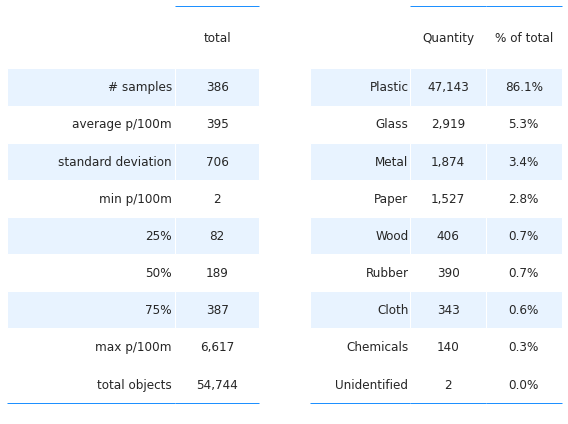

In [9]:
# get the basic statistics from pd.describe
cs = dt_all[unit_label].describe().round(2)

# add project totals
cs["total objects"] = dt_all.quantity.sum()

# change the names
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="EN"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

fd_mat_totals = sut.the_ratio_object_to_total(code_totals)
fd_mat_totals = sut.fmt_pct_of_total(fd_mat_totals)
fd_mat_totals = sut.make_string_format(fd_mat_totals)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Quantity", "% of total":"% of total"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,6))

# summary table
# names for the table columns
a_col = ["All survey areas", "total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
glue("summarymaterial", fig, display=False)
plt.show()

```{glue:figure} summarymaterial
:name: "summarymaterial"

` `
```

{numref}`Figure {number}: <summarymaterial>` __Left:__ Summary of survey totals for all survey areas. __Right:__     Material type and percent of total for all survey areas. 

In [10]:
# # figure caption
# material_type = F"""
# *__Right:__ {top_name[0]} material type and percent of total*
# """
# md(material_type)

## The most common objects

The most common objects are the __ten most abundant by quantity AND/OR objects identified in at least 50% of all surveys__. 

In [11]:
# the top ten by quantity
most_abundant = code_totals.sort_values(by="quantity", ascending=False)[:10]

# the most common
most_common = code_totals[code_totals["fail rate"] >= a_fail_rate ].sort_values(by="quantity", ascending=False)

# merge with most_common and drop duplicates
m_common = pd.concat([most_abundant, most_common]).drop_duplicates()

# get percent of total
m_common_percent_of_total = m_common.quantity.sum()/code_totals.quantity.sum()

# format values for table
m_common["item"] = m_common.index.map(lambda x: code_description_map.loc[x])
m_common["% of total"] = m_common["% of total"].map(lambda x: F"{x}%")
m_common["quantity"] = m_common.quantity.map(lambda x: "{:,}".format(x))
m_common["fail rate"] = m_common["fail rate"].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: F"{np.ceil(x)}")

# # figure caption
# rb_string = F"""
# {top_name[0]} most common objects: fail rate >/= {a_fail_rate}%  and/or top ten by quantity.

# *Combined, the most abundant objects represent {int(m_common_percent_of_total*100)}% of all objects found.*

# Note : {unit_label} = median survey value.
# """
# md(rb_string)

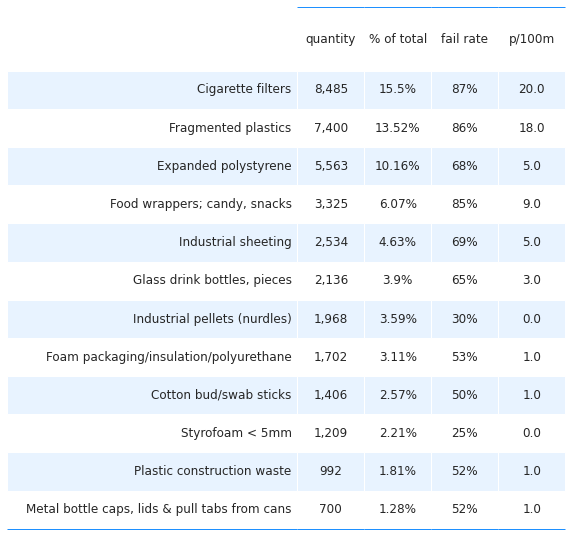

In [12]:
# final table data
cols_to_use = {"item":"Item","quantity":"quantity", "% of total":"% of total", "fail rate":"fail rate", unit_label:unit_label}
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(10,len(m_common)*.8))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.52, .12,.12,.12, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
glue("mcommoneos", fig, display=False)
plt.close()

```{glue:figure} mcommoneos
:name: "mcommon_eos"

` `

```

{numref}`Figure {number}: <mcommon_eos>`      The most common objects for all survey areas. The fail rate is the number of times an object was identified with respect to the number of surveys. Combined, the most common objects represent 68% of total objects found.

__Most common objects median p/100m by survey area__

In [13]:
rb_string = F"""
*{top_name[0]} most common objects: median {unit_label}*
"""
md(rb_string)


*All survey areas most common objects: median p/100m*


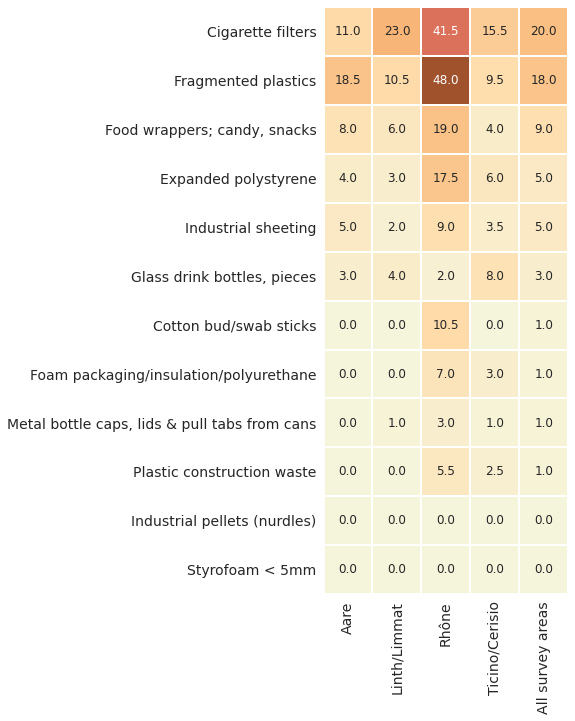

In [14]:
# aggregated survey totals for the most common codes for all the survey areas
# aggregate the code totals by survey and then get the median value per survey
m_common_st = fd[fd.code.isin(m_common.index)].groupby([this_level, "loc_date","code"], as_index=False).agg(agg_pcs_quantity)
m_common_ft = m_common_st.groupby([this_level, "code"], as_index=False)[unit_label].median()

# proper name of water feature for display
m_common_ft["f_name"] = m_common_ft[this_level].map(lambda x: comp_labels[x])

# map the desctiption to the code
m_common_ft["item"] = m_common_ft.code.map(lambda x: code_description_map.loc[x])

# pivot that
m_c_p = m_common_ft[["item", unit_label, "f_name"]].pivot(columns="f_name", index="item")

# quash the hierarchal column index
m_c_p.columns = m_c_p.columns.get_level_values(1)

# the aggregated totals of all the data
a_s_a = fd[fd.code.isin(m_common.index)].groupby(["water_name_slug", "loc_date", "code"], as_index=False).agg(agg_pcs_quantity)
a_s_a_cols = sut.aggregate_to_code(a_s_a, code_description_map,name=top_name[0])

ad_t_ten = pd.concat([m_c_p, a_s_a_cols], axis=1).sort_values(by=top_name[0], ascending=False)

# chart that
fig, ax  = plt.subplots(figsize=(len(ad_t_ten.columns)*.9,len(ad_t_ten)*.9))
axone = ax

sns.heatmap(ad_t_ten, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".1f", square=True, cbar=False, linewidth=.1, linecolor="white")

axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both")

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
glue("mcommonpcs", fig, display=False)
plt.close()

```{glue:figure} mcommonpcs
:name: "mcommon_pcs"

` `

```

{numref}`Figure {number}: <mcommon_pcs>`     The median p/100m of the most common objects for all survey areas. The rates at which the most common objects are identified are different for each survey area.

__Most common objects monthly average__

In [15]:
# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(["loc_date","date","code", "groupname"], as_index=False).agg(agg_pcs_quantity)
m_common_m["date"] = pd.to_datetime(m_common_m["date"], format="%Y-%m-%d")
m_common_m.set_index("date", inplace=True)
# m_common_m.index = pd.to_datetime(m_common_m.in)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(["code","groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values

# a manager dict for the monthly results of each code
mgr = {}

# get the monhtly results for each code:
for a_group in an_order:
    # resample by month
    a_plot = m_common_m[(m_common_m.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

# monthly_mc = F"""
# *{top_name[0]}, monthly average survey result {unit_label}*

# *Detail of the most common objects*
# """
# md(monthly_mc)

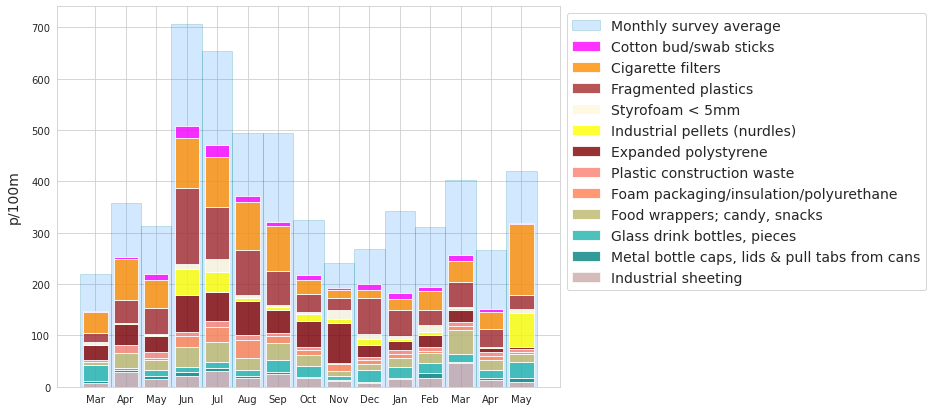

In [16]:

months={
    0:"Jan",
    1:"Feb",
    2:"Mar",
    3:"Apr",
    4:"May",
    5:"Jun",
    6:"Jul",
    7:"Aug",
    8:"Sep",
    9:"Oct",
    10:"Nov",
    11:"Dec"
}

# convenience function to lable x axis
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

fig, ax = plt.subplots(figsize=(9,7))

# define a bottom
bottom = [0]*len(mgr["G27"])

# the monhtly survey average for all objects and locations
monthly_fd = dt_all.copy()
monthly_fd.set_index("date", inplace=True)
m_fd = monthly_fd[unit_label].resample("M").mean().fillna(0)

# define the xaxis
this_x = [i for i,x in  enumerate(m_fd.index)]

# plot the monthly total survey average
ax.bar(this_x, m_fd.to_numpy(), color=a_color, alpha=0.2, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average") 

# plot the monthly survey average of the most common objects
for i, a_group in enumerate(an_order): 
    
    # define the axis
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    
    # collect the month
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    # if i == 0 laydown the first bars
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    # else use the previous results to define the bottom
    else:
        bottom += mgr[an_order[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)
        
# collect the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# set the location of the x ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))
ax.set_ylabel(unit_label, **ck.xlab_k14)

# label the xticks by month
axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# make the legend
# swap out codes for descriptions
new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]

# insert a label for the monthly average
new_labels.insert(0,"Monthly survey average")
handles = [handles[0], *handles[1:][::-1]]
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)
glue("monthlyeos", fig, display=False)
plt.show()

```{glue:figure} monthlyeos
:name: "monthly_eos"


` `

```

{numref}`Figure {number}: <monthly_eos>` Monthly average survey result as p/100m of the most common objects for all survey areas. 

## Survey results and land use

The survey results with respect to land use at the national level are discussed in detail in [The land use profile](luseprofile) and [Shared responsibility](transport).

## Utility of the objects found

The utility type is based on the utilization of the object prior to it being discarded or item description if the original use is undetermined. Identified objects are classified into one of the predefined categories. The categories are grouped according to utilization or item description. 

*  **wastewater**: items released from water treatment plants includes items likely toilet flushed   
*  **micro plastics (< 5mm)**: fragmented plastics and pre-production plastic resins 
*  **infrastructure**: items related to construction and maintenance of buildings, roads and water/power supplies 
*  **food and drink**: all materials related to consuming food and drink
*  **agriculture**: primarily industrial sheeting i.e., mulch and row covers, greenhouses, soil fumigation, bale wraps. Includes hard plastics for agricultural fencing, flowerpots etc. 
*  **tobacco**: primarily cigarette filters, includes all smoking related material 
*  **recreation**: objects related to sports and leisure i.e., fishing, hunting, hiking etc.
*  **packaging non food and drink**: packaging material not identified as food, drink nor tobacco related 
*  **plastic fragments**: plastic pieces of undetermined origin or use 
*  **personal items**: accessories, hygiene and clothing related 

See the annex for the complete list of objects identified, includes descriptions and group classification. The section [Code groups](codegroups) describes each code group in detail and provides a comprehensive list of all objects in a group.

In [17]:
cg_poft = F"""
{top_name[0]} utility of objects found % of total by survey area. Fragmented objects with no clear identification remain classified by size:
"""
md(cg_poft)


All survey areas utility of objects found % of total by survey area. Fragmented objects with no clear identification remain classified by size:


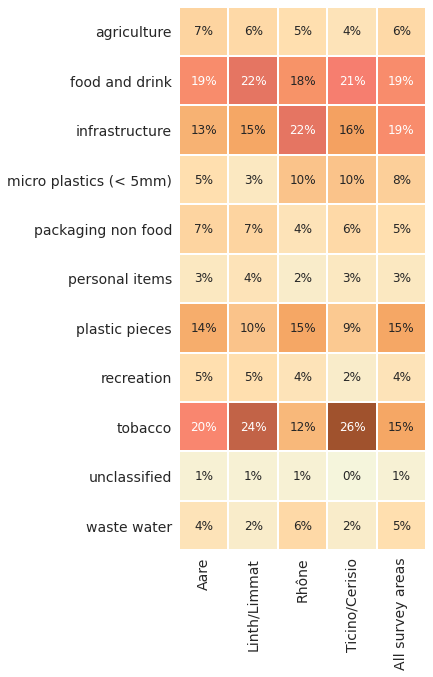

In [18]:
# code groups aggregated by survey for each survey area
groups = ["loc_date","groupname"]
cg_t = fd.groupby([this_level,"loc_date", "groupname"], as_index=False).agg(agg_pcs_quantity)

# get the fail rates for each group per survey
cg_t["fail"]=False
cg_t["fail"] = cg_t.quantity.where(lambda x: x == 0, True)

# aggregate all that for each survey area
cg_t = cg_t.groupby([this_level, "groupname"], as_index=False).agg({unit_label:"median", "quantity":"sum", "fail":"sum", "loc_date":"nunique"})

# quantity per water survey area
cg_tq = cg_t.groupby(this_level).quantity.sum()

# assign survey area total to each record
for a_feature in cg_tq.index:
    cg_t.loc[cg_t[this_level] == a_feature, "f_total"] = cg_tq.loc[a_feature]

# get the percent of total for each group for each survey area
cg_t["pt"] = (cg_t.quantity/cg_t.f_total).round(2)

# pivot that
data_table = cg_t.pivot(columns=this_level, index="groupname", values="pt")

# repeat for all the data
a_s_a = fd.groupby(["water_name_slug", *groups], as_index=False).agg(agg_pcs_quantity)
a_s_a_cols = sut.aggregate_to_group_name(a_s_a, unit_label=unit_label, column="groupname", name=top_name[0], val="pt")

data = pd.concat([data_table, a_s_a_cols], axis=1)
data.rename(columns={x:comp_labels[x] for x in data.columns[:-1]}, inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, cbar=False, fmt=".0%", linewidth=.1, square=True, linecolor="white")

axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)
glue("utility", fig, display=False)

plt.show()

```{glue:figure} utility
:name: "utility_eos"


` `

```

{numref}`Figure {number}: <utility_eos>` The utility of objects as a % of total for all the survey areas.  

In [19]:
cg_medpcm = F"""
{top_name[0]} utility of objects found median {unit_label}. Fragmented objects with no clear identification remain classified by size:
"""
md(cg_medpcm)


All survey areas utility of objects found median p/100m. Fragmented objects with no clear identification remain classified by size:


__Utility of objects as p/100m__

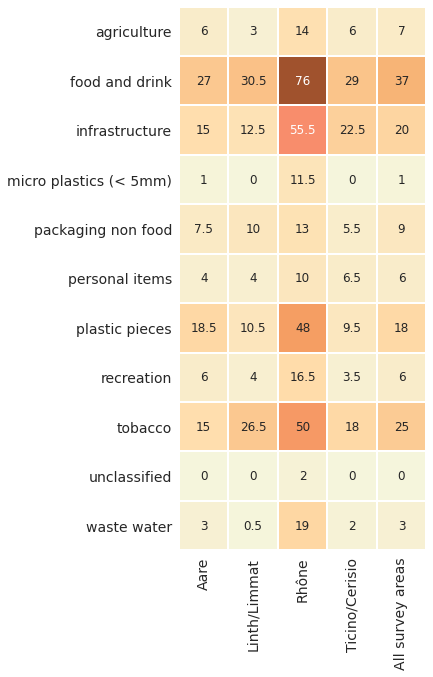

In [20]:
# median p/50m solve cg_t for unit_label
data_table = cg_t.pivot(columns=this_level, index="groupname", values=unit_label)

# column for all the data
a = fd.groupby(["groupname", "loc_date"], as_index=False)[unit_label].sum()
a[top_name[0]] = a[unit_label]
a = a.groupby("groupname")[top_name[0]].median()

# stick that together
data = pd.concat([data_table, a], axis=1)

# format for display
data.rename(columns={x:comp_labels[x] for x in data.columns[:-1]}, inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt="g", cbar=False, linewidth=.1, square=True, linecolor="white")

axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

glue("utility2", fig, display=False)

plt.show()

```{glue:figure} utility2
:name: "utility2_eos"


` `

```

{numref}`Figure {number}: <utility2_eos>` The Rhône survey area has the highest median values for the most common objects. However, as a percentage of total, abundant items related to tobacco, food and drink are less than infrastructure related objects. 

## Rivers

In [21]:
rivers = fd[fd.w_t == "r"].copy()
r_smps = rivers.groupby(["loc_date", "date", "location", "water_name_slug"], as_index=False).agg(agg_pcs_quantity)
l_smps = fd[fd.w_t == "l"].groupby(["loc_date","date","location", "water_name_slug"], as_index=False).agg(agg_pcs_quantity)


# chart_notes = F"""
# *__Left:__ {top_name[0]} rivers, {start_date[:7]} through {end_date[:7]}, n={len(r_smps.loc_date.unique())}. {not_included}
# __Right:__ Summary data.*
# """
# md(chart_notes )

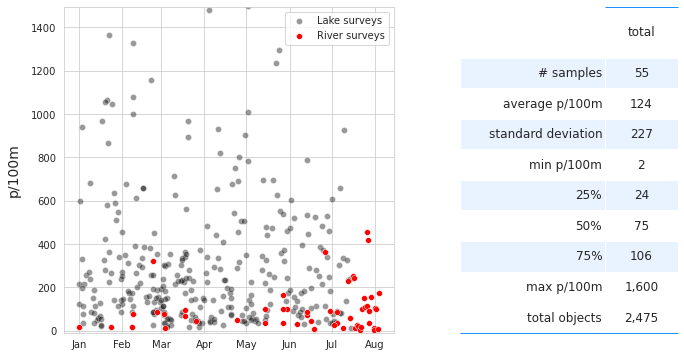

In [22]:
cs = r_smps[unit_label].describe().round(2)

# add project totals
cs["total objects"] = r_smps.quantity.sum()

# change the names
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="EN"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

# make the charts
fig = plt.figure(figsize=(11,6))

aspec = fig.add_gridspec(ncols=11, nrows=3)

ax = fig.add_subplot(aspec[:, :6])

line_label = F"{rate} median:{top_name[0]}"

sns.scatterplot(data=l_smps, x="date", y=unit_label, color="black", alpha=0.4, label="Lake surveys", ax=ax)
sns.scatterplot(data=r_smps, x="date", y=unit_label, color="red", s=34, ec="white",label="River surveys", ax=ax)

ax.set_ylim(-10,y_limit)

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_major_locator(months_loc)
ax.xaxis.set_major_formatter(months_fmt)

a_col = [top_name[0], "total"]

axone = fig.add_subplot(aspec[:, 7:])
sut.hide_spines_ticks_grids(axone)

table_five = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_five.get_celld()[(0,0)].get_text().set_text(" ")

# a_table = axone.table(cellText=combined_summary[:-1],  colLabels=a_col, colWidths=[.5,.25,.25], loc="lower center", bbox=[0,0,1,1])
# the_material_table_data = sut.make_a_summary_table(a_table,combined_summary[:-1],a_col, s_et_bottom_row=False)

glue("rivers", fig, display=False)

plt.show()

```{glue:figure} rivers
:name: "riversx"


` `

```

{numref}`Figure {number}: <riversx>` *Left* All survey areas river survey totals, 2020-03 through 2021-05, n=55. Values greater than 2324.3p/100m 98% not shown. *Right:* Summary data.

__Most common objects__

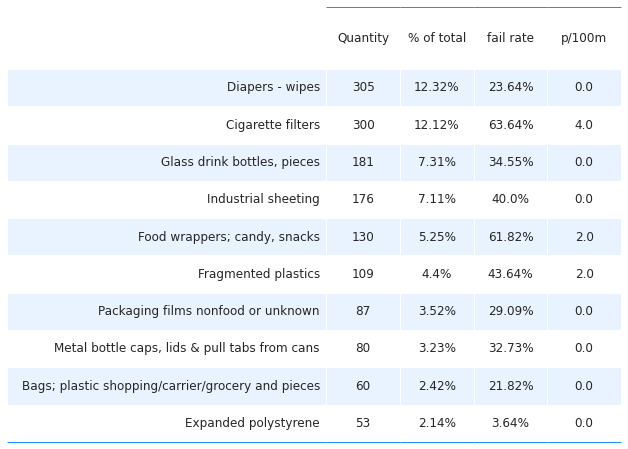

In [23]:
# the most common items rivers
r_codes = rivers.groupby("code").agg({"quantity":"sum", "fail":"sum", unit_label:"median"})
r_codes["fail rate"] = (r_codes.fail/r_smps.loc_date.nunique()*100).round(2)

# top ten
r_byq = r_codes.sort_values(by="quantity", ascending=False)[:10]

# most common
r_byfail = r_codes[r_codes["fail rate"] >= a_fail_rate]
r_common = list(set(r_byq) | set(r_byfail))

r_mc = pd.concat([r_byfail, r_byq]).drop_duplicates()
# format for display
r_mc["item"] = r_mc.index.map(lambda x: code_description_map.loc[x])
r_mc.sort_values(by="quantity", ascending=False, inplace=True)

r_mc["% of total"]=((r_mc.quantity/r_codes.quantity.sum())*100).round(2)
r_mc["% of total"] = r_mc["% of total"].map(lambda x: F"{x}%")
r_mc["quantity"] = r_mc.quantity.map(lambda x: "{:,}".format(x))
r_mc["fail rate"] = r_mc["fail rate"].map(lambda x: F"{x}%")
r_mc[unit_label] = r_mc[unit_label].map(lambda x: F"{np.ceil(x)}")

cols_to_use = {"item":"Item","quantity":"Quantity"}
r_mc.rename(columns=cols_to_use, inplace=True)

data=r_mc[["Item","Quantity", "% of total", "fail rate", unit_label]]

fig, axs = plt.subplots(figsize=(11,len(data)*.8))

sut.hide_spines_ticks_grids(axs)

table_six = sut.make_a_table(axs, data.values,  colLabels=data.columns, colWidths=[.52, .12,.12,.12, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_six.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
glue("rivers2", fig, display=False)
plt.close()

```{glue:figure} rivers2
:name: "rivers_2"


` `

```

{numref}`Figure {number}: <rivers_2>` The most common objects from river surveys. Diapers - wipes and plastic bags are not present in the most common objects when lakes are considered.

## Annex

### Fragmented foams and plastics by size group

These are the components of Gfoam and Gfrags, objects labled "Expanded foams" are grouped with Gfoam the rest are grouped under Gfrags.

In [24]:
frag_foams = F"""
*{top_name[0]} fragmented foams and plastics by size group.* 
"""
md(frag_foams)


*All survey areas fragmented foams and plastics by size group.* 


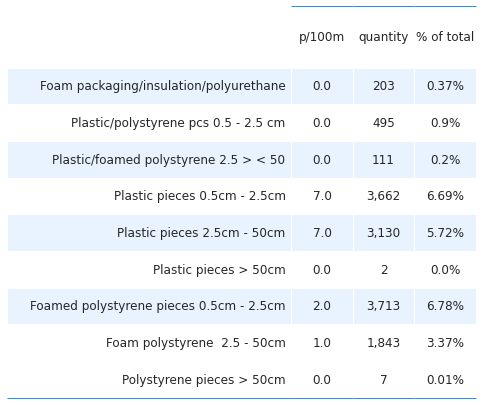

In [25]:
# collect the data before aggregating foams for all locations in the survye area
# group by loc_date and code
# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ["G81", "G82", "G83", "G74"]

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())

fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(fd.location.unique()))].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg({unit_label:"median", "quantity":"sum"})

# add code description and format for printing
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: code_description_map.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams["% of total"] = fd_frags_foams["% of total"].map(lambda x: F"{x}%")
fd_frags_foams["quantity"] = fd_frags_foams["quantity"].map(lambda x: F"{x:,}")

# table data
data = fd_frags_foams[["item",unit_label, "quantity", "% of total"]]

fig, axs = plt.subplots(figsize=(len(data.columns)*2.1,len(data)*.8))
sut.hide_spines_ticks_grids(axs)

table_seven = sut.make_a_table(axs, data.values,  colLabels=data.columns, colWidths=[.6, .13, .13, .13],a_color=a_color)
table_seven.get_celld()[(0,0)].get_text().set_text(" ")


plt.show()
plt.tight_layout()
plt.close()

### Organizations:

1. Precious Plastic Léman
2. Association pour la Sauvegarde du Léman
3. Geneva international School
4. Solid waste engineering: École polytechnique fédéral Lausanne
5. Summit foundation
6. University of Raperswill
7. Hackuarium

### Municipalities, lakes and rivers with surveys

In [26]:
lakes = dfBeaches.loc[(dfBeaches.index.isin(fd.location.unique()))&(dfBeaches.water == "l")]["water_name"].unique()
rivers = dfBeaches.loc[(dfBeaches.index.isin(fd.location.unique()))&(dfBeaches.water == "r")]["water_name"].unique()


# gather the municpalities and the population:
fd_pop_map = dfBeaches.loc[fd.location.unique()][["city","population"]].copy()
fd_pop_map.drop_duplicates(inplace=True)
fd_pop_map.set_index("city", drop=True, inplace=True)
munis_joined = ", ".join(sorted(fd_pop_map.index))

muni_string = F"""**The municipalities in this report:**\n\n{munis_joined}
"""
md(muni_string)

**The municipalities in this report:**

Aarau, Allaman, Ascona, Beatenberg, Bellinzona, Bern, Biel/Bienne, Boudry, Bourg-en-Lavaux, Brienz (BE), Brissago, Brugg, Brügg, Burgdorf, Bönigen, Cheyres-Châbles, Cudrefin, Dietikon, Erlach, Estavayer, Freienbach, Gals, Gambarogno, Gebenstorf, Genève, Gland, Glarus Nord, Grandson, Hauterive (NE), Hünenberg, Kallnach, Köniz, Küsnacht (ZH), La Tour-de-Peilz, Lausanne, Lavey-Morcles, Le Landeron, Leuk, Ligerz, Locarno, Lugano, Luterbach, Lüscherz, Merenschwand, Minusio, Montreux, Neuchâtel, Nidau, Port, Préverenges, Quarten, Rapperswil-Jona, Richterswil, Riddes, Rubigen, Saint-Gingolph, Saint-Sulpice (VD), Salgesch, Schmerikon, Sion, Solothurn, Spiez, Stäfa, Thun, Tolochenaz, Unterengstringen, Unterseen, Versoix, Vevey, Vinelz, Walenstadt, Walperswil, Weesen, Weggis, Yverdon-les-Bains, Zug, Zürich


In [27]:
lakes_joined = ", ".join(sorted(lakes))

lake_string = F"""**The lakes in this report:**\n\n{lakes_joined}
"""
md(lake_string)

**The lakes in this report:**

Bielersee, Brienzersee, Lac Léman, Lago Maggiore, Lago di Lugano, Neuenburgersee, Quatre Cantons, Thunersee, Walensee, Zugersee, Zurichsee


In [28]:
rivers_joined = ", ".join(sorted(rivers))

river_string = F"""**The rivers in this report:**\n\n{rivers_joined}
"""
md(river_string)

**The rivers in this report:**

Aare, Aare|Nidau-Büren-Kanal, Cassarate, Dorfbach, Emme, Escherkanal, Jona, La Thièle, Limmat, Linthkanal, Maggia, Reuss, Rhône, Schüss, Seez, Sihl, Ticino


In [29]:
# summary statistics:
# number of samples
fd_n_samps = len(dt_all)
# quantity
fd_n_obj = fd.quantity.sum()
# number of locations
fd_n_locs = fd.location.nunique()
# number of cities
fd_n_munis = len(fd_pop_map.index)
# populations
fd_effected_population = fd_pop_map.sum()
# list of locations
fd_locs = fd.location.unique()
# list of survey keys
fd_samps = fd.loc_date.unique()


obj_string = "{:,}".format(fd_n_obj)
surv_string = "{:,}".format(fd_n_samps)
pop_string = "{:,}".format(int(fd_effected_population[0]))

date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, {obj_string } objects were removed and identified in the course of {surv_string} surveys."
geo_context = F"Those surveys were conducted at {fd_n_locs} different locations."
admin_context = F"There are {fd_n_munis} different municipalities represented in these results with a combined population of approximately {pop_string}."
md(F"{date_quantity_context} {geo_context } {admin_context}")

For the period between 2020-03 and 2021-05, 54,744 objects were removed and identified in the course of 386 surveys. Those surveys were conducted at 143 different locations. There are 77 different municipalities represented in these results with a combined population of approximately 1,735,991.

In [30]:
pd.set_option("display.max_rows", None)
complete_inventory = code_totals[code_totals.quantity>0][["item", "groupname", "quantity", "% of total","fail rate"]]
complete_inventory.sort_values(by="quantity", ascending=False)

,item,groupname,quantity,% of total,fail rate
code,,,,,
G27,Cigarette filters,tobacco,8485,15.50,87
Gfrags,Fragmented plastics,plastic pieces,7400,13.52,86
Gfoam,Expanded polystyrene,infrastructure,5563,10.16,68
G30,"Food wrappers; candy, snacks",food and drink,3325,6.07,85
G67,Industrial sheeting,agriculture,2534,4.63,69
G200,"Glass drink bottles, pieces",food and drink,2136,3.90,65
G112,Industrial pellets (nurdles),micro plastics (< 5mm),1968,3.59,30
G74,Foam packaging/insulation/polyurethane,infrastructure,1702,3.11,53
G95,Cotton bud/swab sticks,waste water,1406,2.57,50
